<a href="https://colab.research.google.com/github/meleeshagamage/CourseWork_ML/blob/main/ML_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK 1

In [252]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping

import itertools

print("Libraries loaded")

Libraries loaded


In [253]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [254]:
#Import the dataset
df = pd.read_csv('/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [255]:
#Get the shape
print("Shape:", df.shape)
df.info()

Shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

In [256]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [257]:
#Count Missing Values
print("Missing values after cleaning:")
print(df.isnull().sum())

Missing values after cleaning:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


### EDA visualizations


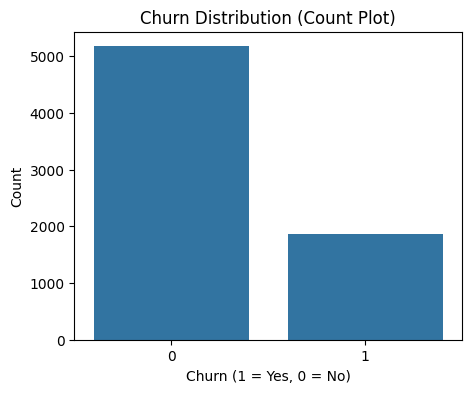

In [258]:
# Convert churn columnif needed
df['Churn_numeric'] = df['Churn'].map({'Yes':1, 'No':0})

# Plot 'Churn' feature
plt.figure(figsize=(5,4))
sns.countplot(x='Churn_numeric', data=df)
plt.title('Churn Distribution (Count Plot)')
plt.xlabel('Churn (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()



Numeric cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_numeric']


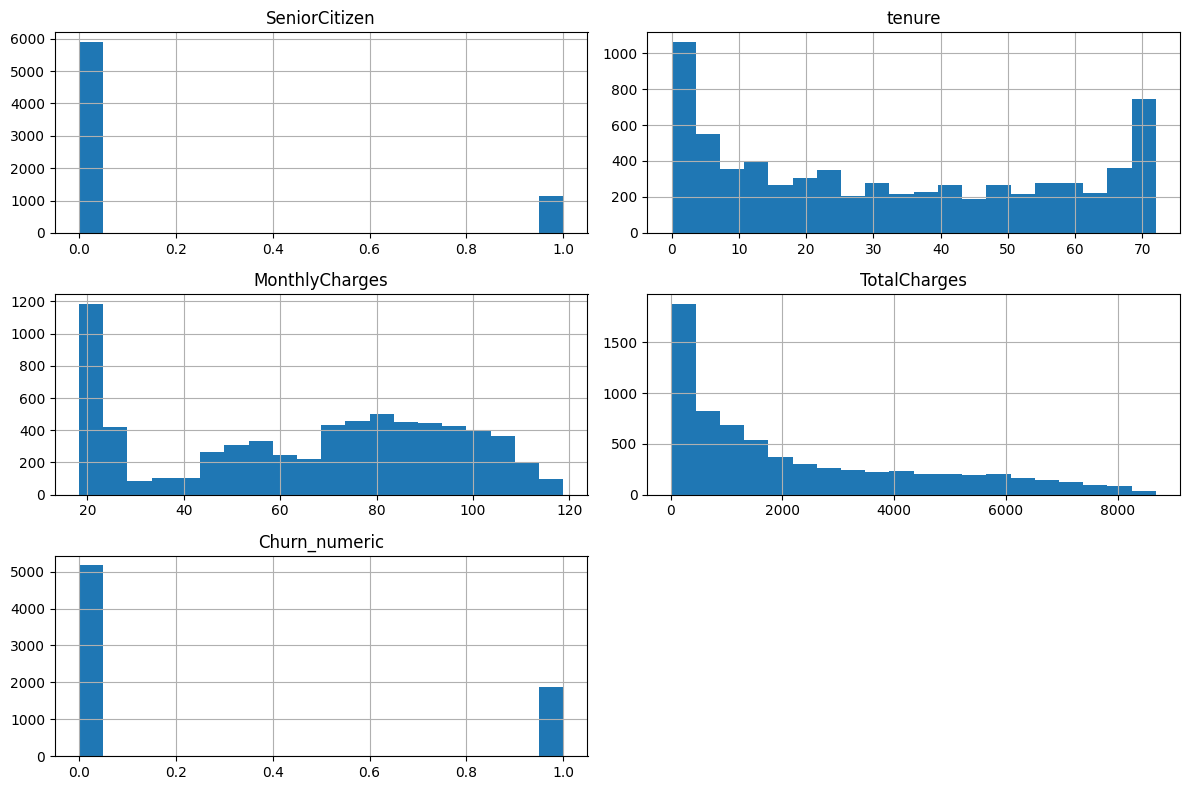

In [259]:
# Numeric columns histograms
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print("Numeric cols:", num_cols)
df[num_cols].hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()

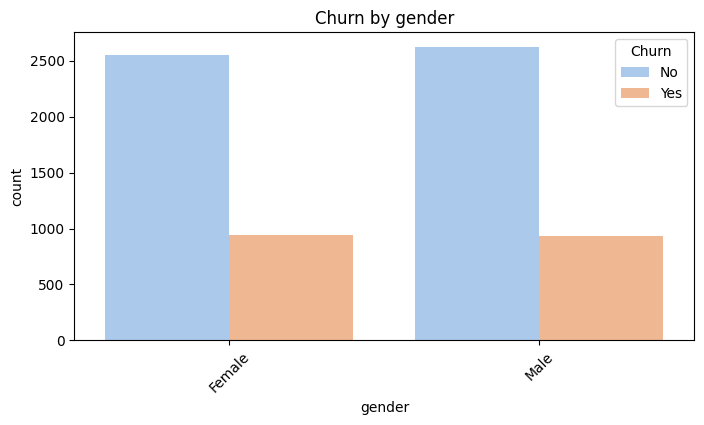

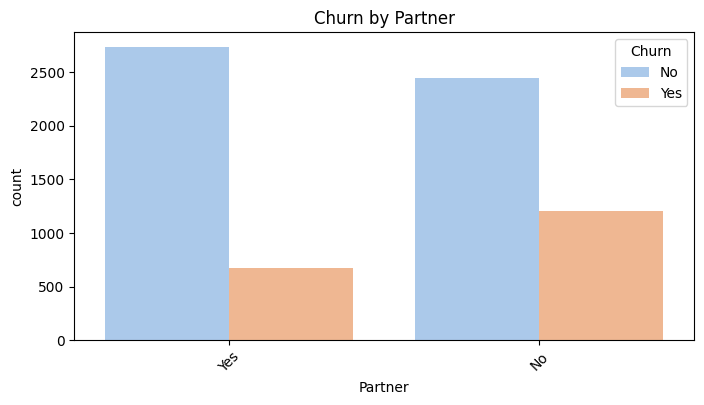

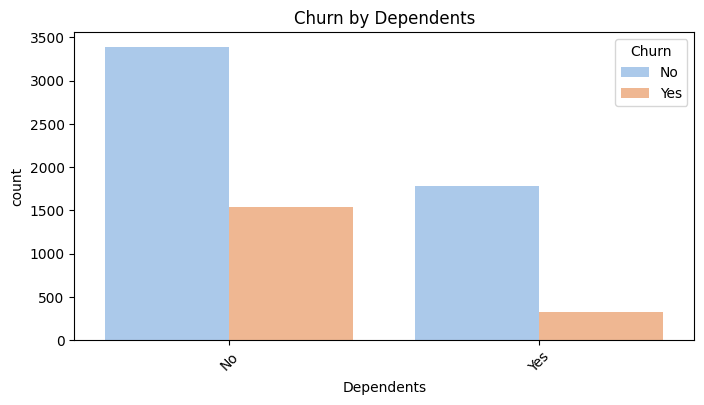

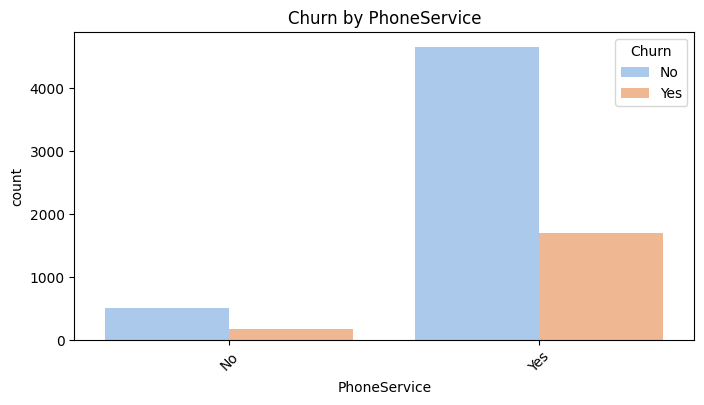

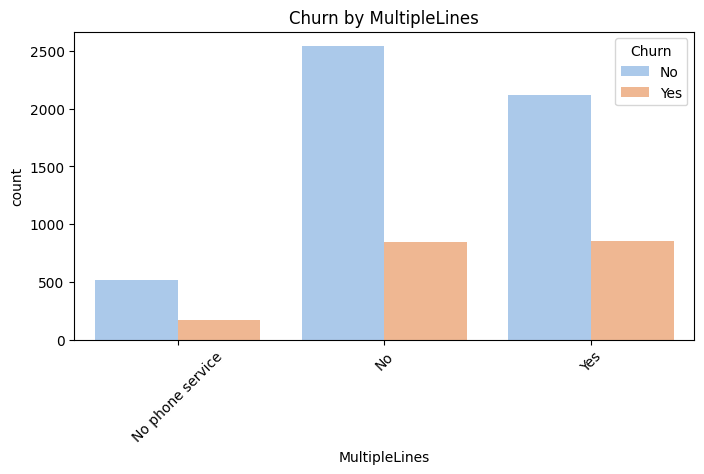

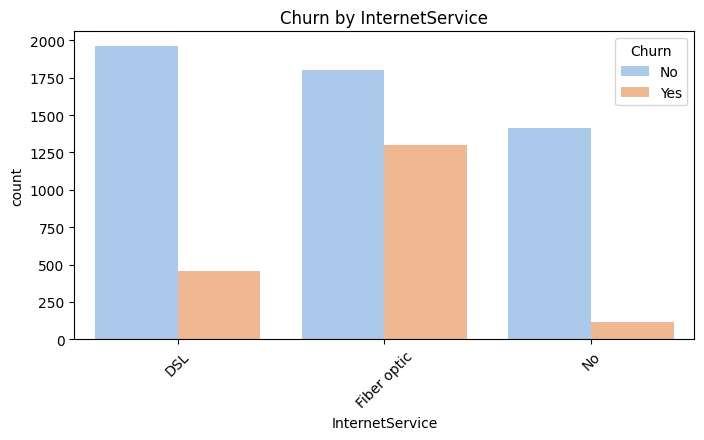

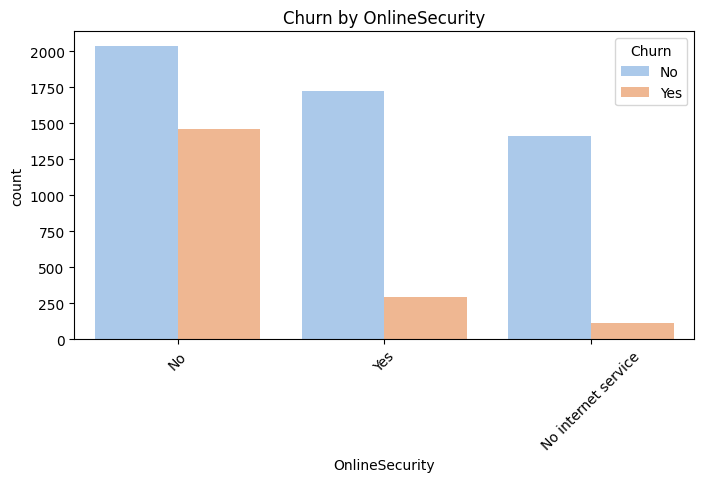

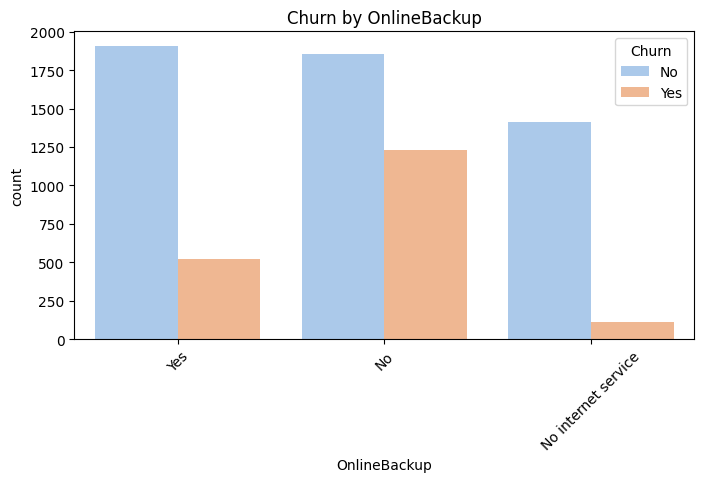

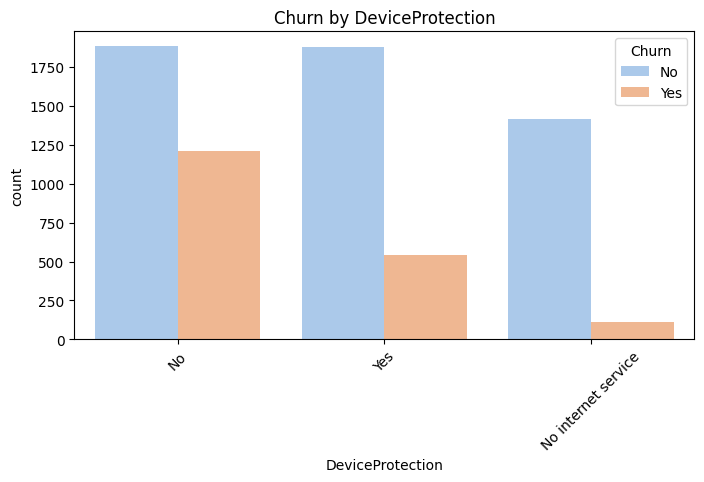

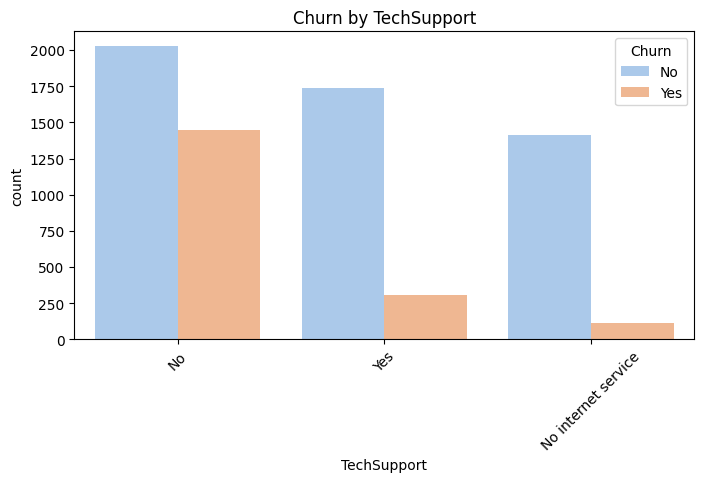

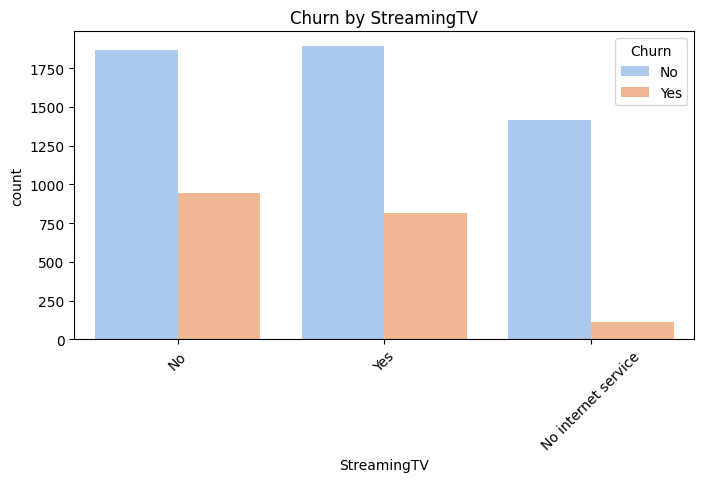

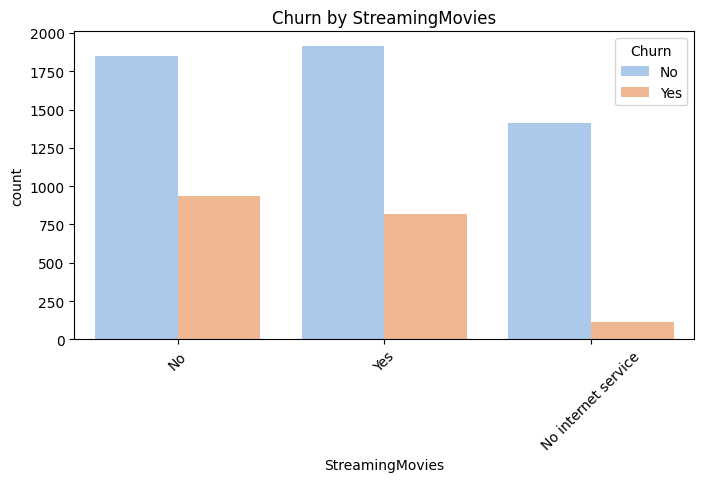

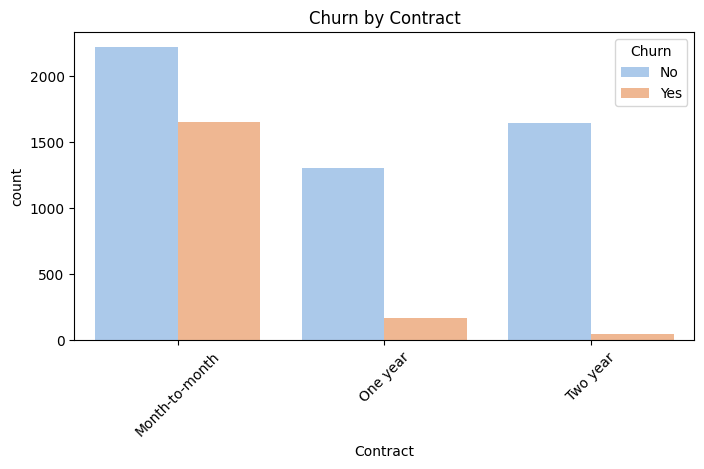

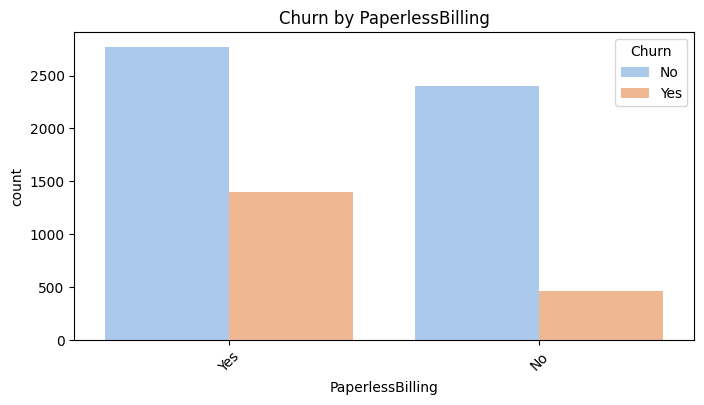

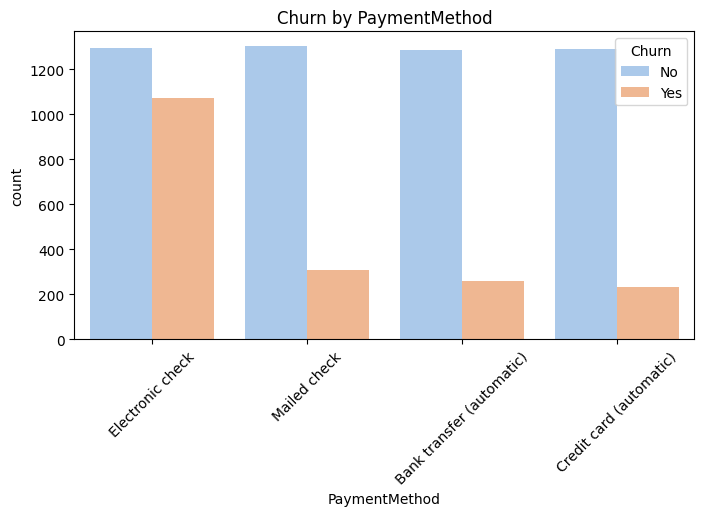

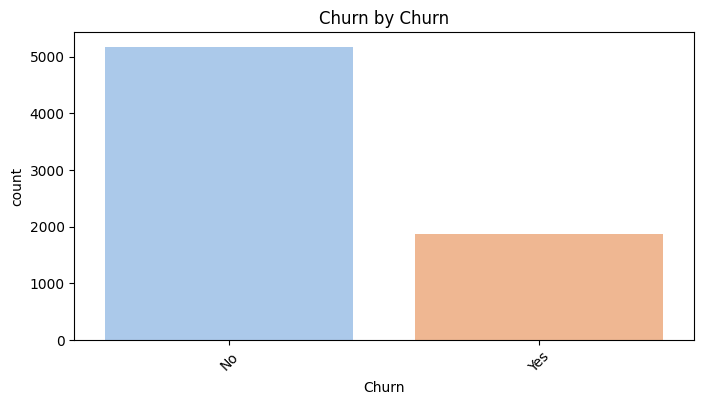

In [260]:
# Categorical columns  distributions
categorical_cols = df.select_dtypes(include=['object']).columns.drop('customerID')

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='Churn', data=df, palette='pastel')
    plt.title(f'Churn by {col}')
    plt.xticks(rotation=45)
    plt.show()


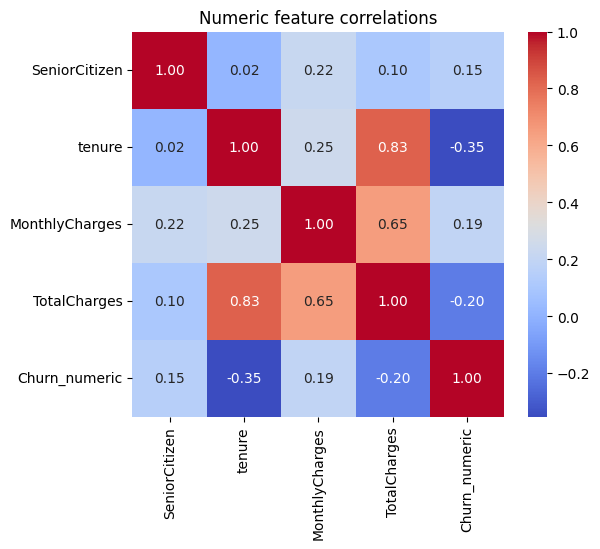

In [261]:
# Correlation heatmap among numeric features
plt.figure(figsize=(6,5))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Numeric feature correlations')
plt.show()

### Data Cleaning

In [262]:
# Drop 'customerID' column
df = df.drop(columns=['customerID'], errors='ignore')

In [263]:
# Fill missing values with Median
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [264]:
# Drop 'Churn_numeric' feature
df = df.drop(columns=['Churn_numeric'], errors='ignore')

In [265]:
# Encode target
df['Churn'] = df['Churn'].map({'Yes':1,'No':0})

### Train-test split

In [266]:
# Split Data
y = df['Churn']
X = df.drop(columns=['Churn'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [267]:
# After spliting the data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (5634, 19)
X_test shape: (1409, 19)
y_train shape: (5634,)
y_test shape: (1409,)


In [268]:
# Check class distribution is maintained
print(f"\nOriginal churn ratio: {df['Churn'].value_counts(normalize=True)}")
print(f"Train churn ratio: {y_train.value_counts(normalize=True)}")
print(f"Test churn ratio: {y_test.value_counts(normalize=True)}")


Original churn ratio: Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64
Train churn ratio: Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64
Test churn ratio: Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


### Processing the Data

In [269]:
# After splitting, identify columns from trainig data only
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()


print("Numeric features for preprocessing:", numeric_features)
print("Categorical features for preprocessing:", categorical_features)

Numeric features for preprocessing: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features for preprocessing: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [270]:
# Build the preprocessing pipeline

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'))

])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

# TASK 2

### Decision Tree with hyperparameter tuning

In [271]:
dt_pipeline = Pipeline(steps=[
    ("preproc", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42))
])

In [272]:
# Preprocess manually for default model
X_train_pp = preprocessor.fit_transform(X_train)
X_test_pp  = preprocessor.transform(X_test)

clf_default = DecisionTreeClassifier(random_state=42)
clf_default.fit(X_train_pp, y_train)

# Predictions
y_pred_default = clf_default.predict(X_test_pp)
y_proba_default = clf_default.predict_proba(X_test_pp)[:, 1]


In [273]:
# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred_default))
print("Precision:", precision_score(y_test, y_pred_default))
print("Recall:", recall_score(y_test, y_pred_default))
print("F1:", f1_score(y_test, y_pred_default))
print("ROC AUC:", roc_auc_score(y_test, y_proba_default))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_default))

Accuracy: 0.7409510290986515
Precision: 0.5125348189415042
Recall: 0.4919786096256685
F1: 0.5020463847203275
ROC AUC: 0.6609574000878348

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1035
           1       0.51      0.49      0.50       374

    accuracy                           0.74      1409
   macro avg       0.67      0.66      0.66      1409
weighted avg       0.74      0.74      0.74      1409



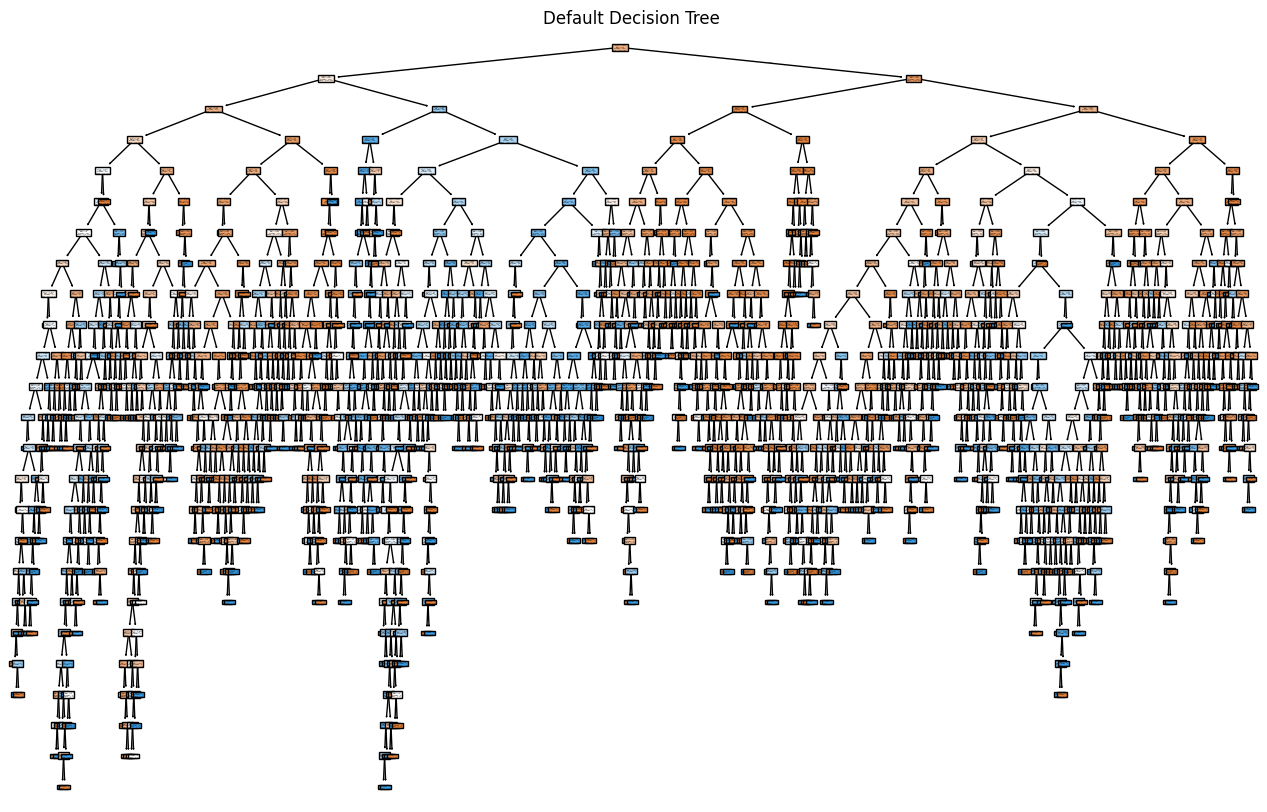

In [274]:
# Plot Default Tree
plt.figure(figsize=(16,10))
plot_tree(clf_default, filled=True)
plt.title("Default Decision Tree ")
plt.show()

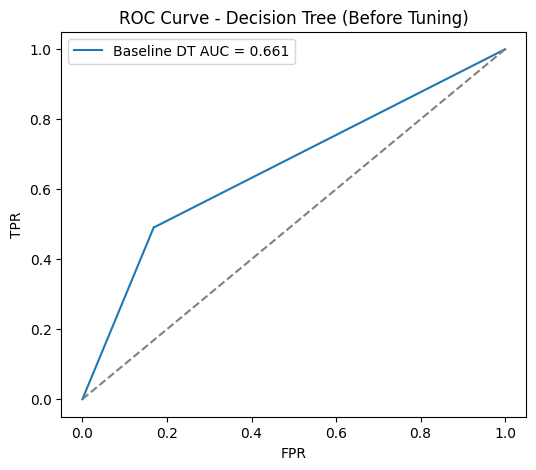

In [275]:
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_default )
auc_base = auc(fpr_base, tpr_base)
plt.figure(figsize=(6, 5))
plt.plot(fpr_base, tpr_base, label=f"Baseline DT AUC = {auc_base:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("ROC Curve - Decision Tree (Before Tuning)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

In [276]:
# Tunes the decision‑tree pipeline’s hyperparameters

param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [3, 5, 8, 12, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__class_weight': [None, 'balanced']
}

grid_dt = GridSearchCV(
    dt_pipeline,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)


grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SeniorCitizen',
                                                                          'tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='...
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod'])])),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__class_weight': [None, 'balanced'],
                         'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [3, 5, 8, 12, None],
                         'clf__min_samples_leaf': [1, 2, 4],
                         'clf__min_samples_split': [2, 5, 10]},
             scoring='f1', verbose=1)

In [277]:
# Get best hyperparameters found
print("Best Decision Tree parameters:")
print(grid_dt.best_params_)
print("\nBest CV F1-score (training CV):")
print(grid_dt.best_score_)

Best Decision Tree parameters:
{'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5}

Best CV F1-score (training CV):
0.6111844563666912


In [278]:
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]


In [279]:
print(" TEST RESULTS ")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1:", f1_score(y_test, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_test, y_proba_dt))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_dt))

 TEST RESULTS 
Accuracy: 0.7324343506032647
Precision: 0.4975609756097561
Recall: 0.8181818181818182
F1: 0.6188068756319515
ROC AUC: 0.8211165362060502

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1035
           1       0.50      0.82      0.62       374

    accuracy                           0.73      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.73      0.75      1409



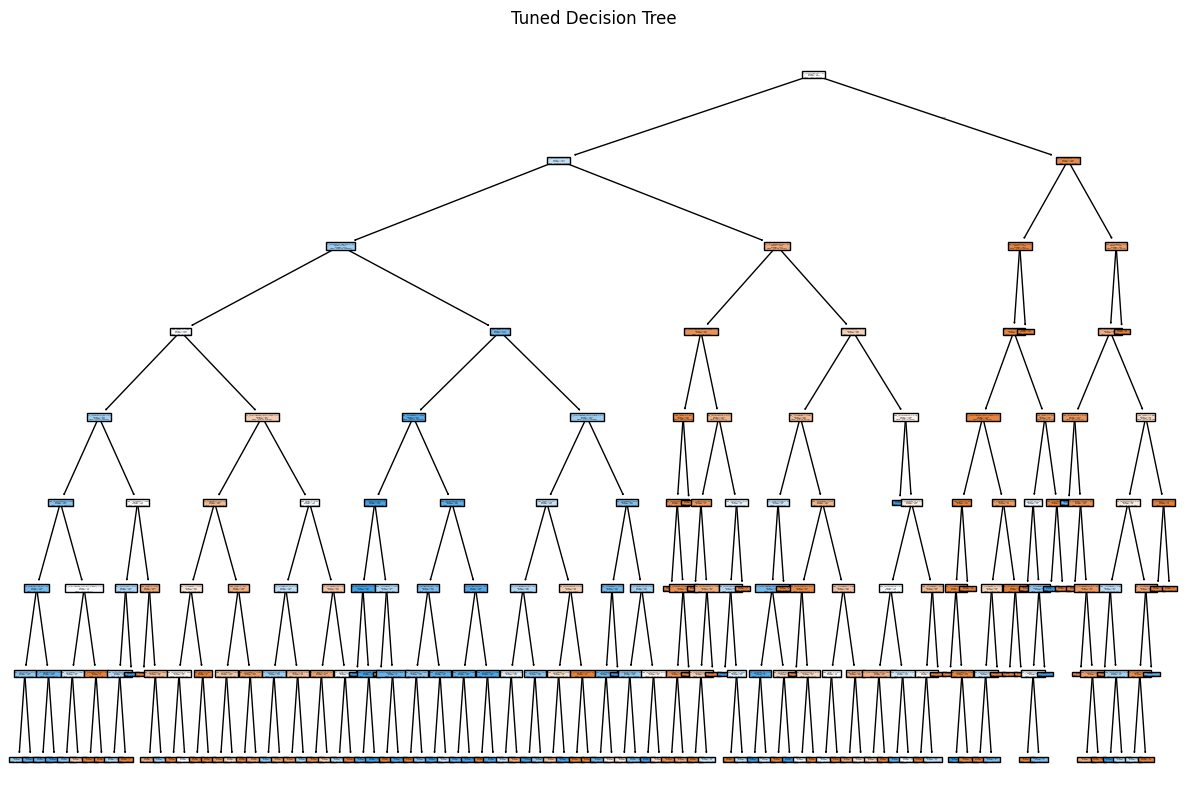

In [280]:
# Tuned pipeline from GridSearchCV
best_dt = grid_dt.best_estimator_

# Get the tuned DecisionTreeClassifier inside the pipeline
clf_tuned = best_dt.named_steps["clf"]
plt.figure(figsize=(15, 10))
tree.plot_tree(
    clf_tuned,
    feature_names=best_dt.named_steps["preproc"].get_feature_names_out(),
    filled=True
)
plt.title("Tuned Decision Tree")
plt.show()

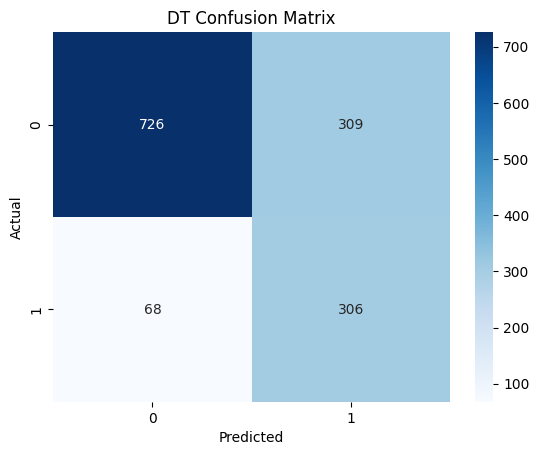

In [281]:
# Plot Confusion_matrix
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('DT Confusion Matrix')
plt.show()

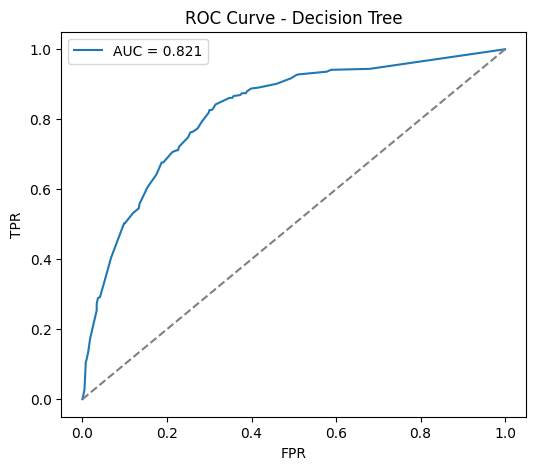

In [282]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_dt)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.title("ROC Curve - Decision Tree")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()


### Neural Network

In [283]:
X_train_pp = preprocessor.fit_transform(X_train)
X_test_pp  = preprocessor.transform(X_test)

# Convert to dense numpy array if needed
X_train_np = X_train_pp.toarray() if hasattr(X_train_pp, "toarray") else X_train_pp
X_test_np  = X_test_pp.toarray()  if hasattr(X_test_pp, "toarray") else X_test_pp

y_train_np = y_train.values if hasattr(y_train, "values") else np.array(y_train)
y_test_np  = y_test.values  if hasattr(y_test, "values") else np.array(y_test)

input_dim = X_train_np.shape[1]
print("Input dimension:", input_dim)



Input dimension: 30


In [284]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [285]:
def build_default_model(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

default_model = build_default_model(input_dim)

history_default = default_model.fit(
    X_train_np, y_train_np,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7629 - loss: 0.4968 - val_accuracy: 0.7879 - val_loss: 0.4410
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8078 - loss: 0.4108 - val_accuracy: 0.8004 - val_loss: 0.4383
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7993 - loss: 0.4117 - val_accuracy: 0.7826 - val_loss: 0.4413
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8121 - loss: 0.4039 - val_accuracy: 0.8030 - val_loss: 0.4415
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8129 - loss: 0.3974 - val_accuracy: 0.8004 - val_loss: 0.4394
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8099 - loss: 0.3960 - val_accuracy: 0.7924 - val_loss: 0.4367
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8089 - loss: 0.3919 - val_accuracy: 0.7968 - val_loss: 0.4364
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8077 - loss: 0.3971 - val_accuracy: 0.

In [286]:
# Predictions and metrics (default)
y_pred_prob_default = default_model.predict(X_test_np).ravel()
y_pred_default = (y_pred_prob_default >= 0.5).astype(int)

metrics_default = {
    'Accuracy': accuracy_score(y_test_np, y_pred_default),
    'Precision': precision_score(y_test_np, y_pred_default, zero_division=0),
    'Recall': recall_score(y_test_np, y_pred_default, zero_division=0),
    'F1-Score': f1_score(y_test_np, y_pred_default, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test_np, y_pred_prob_default)
}
print("Metrics Before Tuning:", metrics_default)

print("\nClassification Report (Before Tuning):\n")
print(classification_report(y_test_np, y_pred_default, zero_division=0))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Metrics Before Tuning: {'Accuracy': 0.8041163946061036, 'Precision': 0.657051282051282, 'Recall': 0.5481283422459893, 'F1-Score': 0.597667638483965, 'ROC-AUC': np.float64(0.8417189800821514)}

Classification Report (Before Tuning):

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.66      0.55      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409



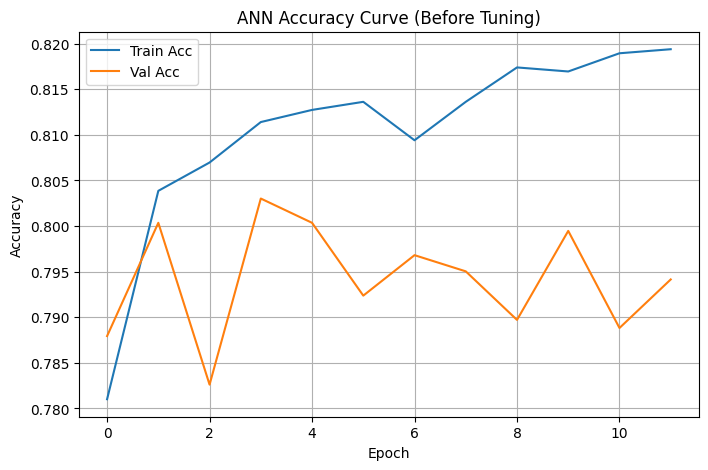

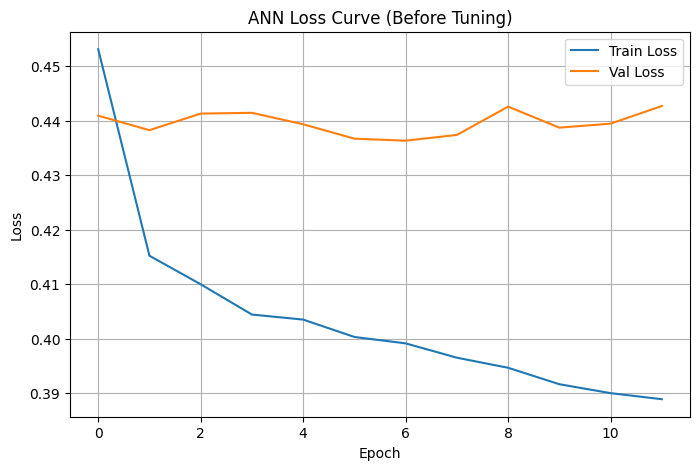

In [287]:
# Plots for default model
plt.figure(figsize=(8,5))
plt.plot(history_default.history['accuracy'], label='Train Acc')
plt.plot(history_default.history['val_accuracy'], label='Val Acc')
plt.title("ANN Accuracy Curve (Before Tuning)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history_default.history['loss'], label='Train Loss')
plt.plot(history_default.history['val_loss'], label='Val Loss')
plt.title("ANN Loss Curve (Before Tuning)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.show()

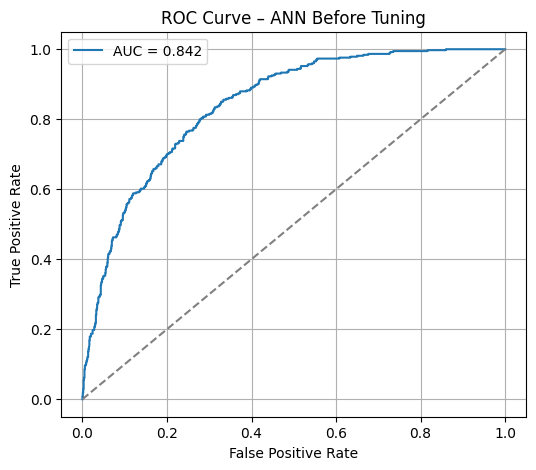

In [288]:
fpr, tpr, _ = roc_curve(y_test_np, y_pred_prob_default)
roc_value = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_value:.3f}")
plt.plot([0,1], [0,1], '--', color='grey')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve – ANN Before Tuning")
plt.legend(); plt.grid(True); plt.show()

In [289]:
!pip install keras-tuner
import keras_tuner as kt

In [290]:
# ANN After Hyperparameter Tuning

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    units = hp.Int('units', 32, 128, step=32)
    layers_count = hp.Int('layers', 1, 3)
    dropout_rate = hp.Float('dropout', 0.0, 0.5, step=0.1)

    # first hidden layer
    model.add(Dense(units, activation='relu'))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # additional hidden layers
    for _ in range(layers_count - 1):
        model.add(Dense(units, activation='relu'))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [291]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='nn_churn'
)

tuner.search(X_train_np, y_train_np, validation_split=0.2, epochs=50, batch_size=32, callbacks=[es])

Reloading Tuner from keras_tuner_dir/nn_churn/tuner0.json


In [292]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(1)[0]
print("\nBest Hyperparameters:", best_hyperparams.values)


best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Best Hyperparameters: {'units': 128, 'layers': 3, 'dropout': 0.4}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [293]:
history_best = best_model.fit(
    X_train_np,
    y_train_np,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7985 - loss: 0.4268 - val_accuracy: 0.7897 - val_loss: 0.4412
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8060 - loss: 0.4248 - val_accuracy: 0.7977 - val_loss: 0.4359
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8004 - loss: 0.4168 - val_accuracy: 0.8012 - val_loss: 0.4328
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8019 - loss: 0.4053 - val_accuracy: 0.7977 - val_loss: 0.4354
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8101 - loss: 0.4093 - val_accuracy: 0.7986 - val_loss: 0.4333
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8217 - loss: 0.3984 - val_accuracy: 0.7986 - val_loss: 0.4344
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8034 - loss: 0.4229 - val_accuracy: 0.7941 - val_loss: 0.4369
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8119 - loss: 0.4080 - val_accuracy: 0

In [294]:
# Predictions
y_pred_prob_best = best_model.predict(X_test_np).ravel()
y_pred_best = (y_pred_prob_best >= 0.5).astype(int)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


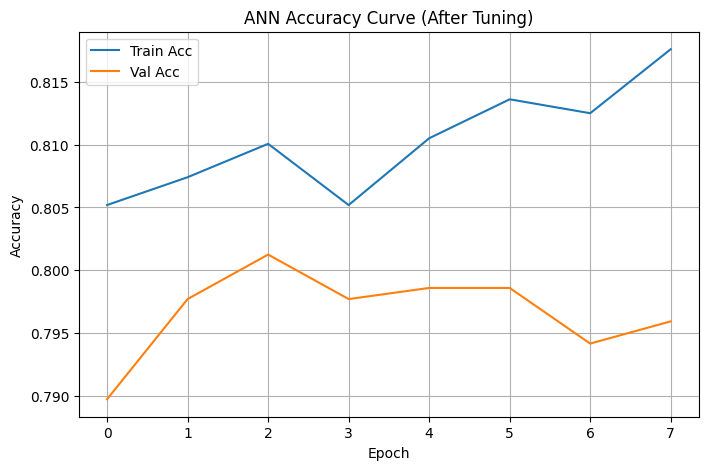

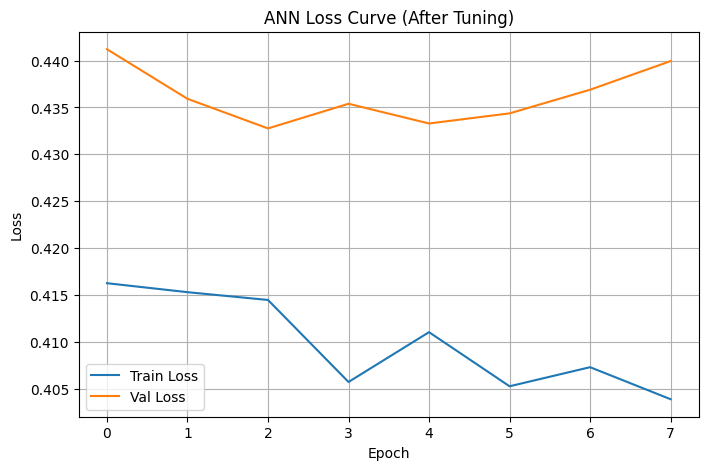

In [295]:
# Plots for tuned model
plt.figure(figsize=(8,5))
plt.plot(history_best.history['accuracy'], label='Train Acc')
plt.plot(history_best.history['val_accuracy'], label='Val Acc')
plt.title("ANN Accuracy Curve (After Tuning)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history_best.history['loss'], label='Train Loss')
plt.plot(history_best.history['val_loss'], label='Val Loss')
plt.title("ANN Loss Curve (After Tuning)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.show()

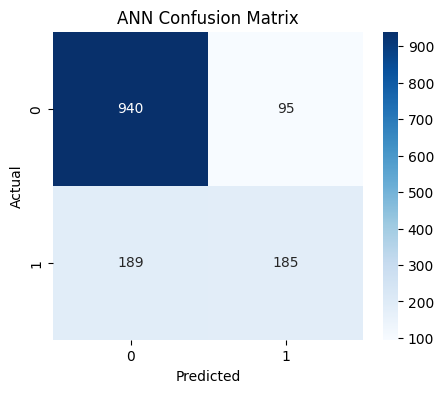

In [296]:
# Confusion matrix
cm = confusion_matrix(y_test_np, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('ANN Confusion Matrix')
plt.show()

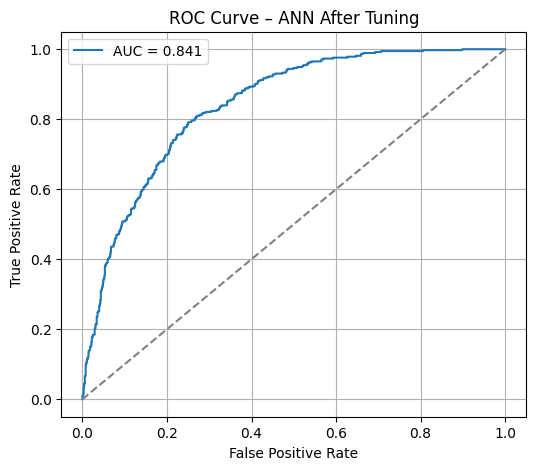

In [297]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test_np, y_pred_prob_best)
roc_value = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_value:.3f}")
plt.plot([0,1],[0,1],'--',color='grey')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve – ANN After Tuning")
plt.legend(); plt.grid(True); plt.show()

In [298]:
# Final ANN Evaluation (After Tuning)
print("Final ANN Evaluation (After Tuning):")
print("Accuracy :", accuracy_score(y_test_np, y_pred_best))
print("Precision:", precision_score(y_test_np, y_pred_best))
print("Recall   :", recall_score(y_test_np, y_pred_best))
print("F1 Score :", f1_score(y_test_np, y_pred_best))
print("ROC-AUC  :", roc_auc_score(y_test_np, y_pred_prob_best))

print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred_best, zero_division=0))

Final ANN Evaluation (After Tuning):
Accuracy : 0.7984386089425124
Precision: 0.6607142857142857
Recall   : 0.4946524064171123
F1 Score : 0.5657492354740061
ROC-AUC  : 0.8411893874809476

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.49      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



### Evaluation  

In [299]:
#  Model Predictions

# ANN Predictions
y_pred_prob_nn = best_model.predict(X_test_np).ravel()
y_pred_nn = (y_pred_prob_nn >= 0.5).astype(int)

# Decision Tree Predictions (best tuned DT)
y_pred_dt = best_dt.predict(X_test)  # if using pipeline, raw X_test works
y_pred_prob_dt = best_dt.predict_proba(X_test)[:, 1]

#  Metrics Dictionaries
metrics_nn = {
    'Accuracy': accuracy_score(y_test_np, y_pred_nn),
    'F1-Score': f1_score(y_test_np, y_pred_nn),
    'ROC-AUC': roc_auc_score(y_test_np, y_pred_prob_nn)
}

metrics_dt = {
    'Accuracy': accuracy_score(y_test_np, y_pred_dt),
    'F1-Score': f1_score(y_test_np, y_pred_dt),
    'ROC-AUC': roc_auc_score(y_test_np, y_pred_prob_dt)
}

#  Create Comparison Table
comparison_dict = {
    'Metric': ['Accuracy', 'F1-Score', 'ROC-AUC'],
    'Neural Network': [
        metrics_nn['Accuracy'], metrics_nn['F1-Score'], metrics_nn['ROC-AUC']
    ],
    'Decision Tree': [
        metrics_dt['Accuracy'], metrics_dt['F1-Score'], metrics_dt['ROC-AUC']
    ]
}

comparison_df = pd.DataFrame(comparison_dict)

print("\n===== MODEL METRICS COMPARISON =====")
print(comparison_df)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

===== MODEL METRICS COMPARISON =====
     Metric  Neural Network  Decision Tree
0  Accuracy        0.798439       0.732434
1  F1-Score        0.565749       0.618807
2   ROC-AUC        0.841189       0.821117


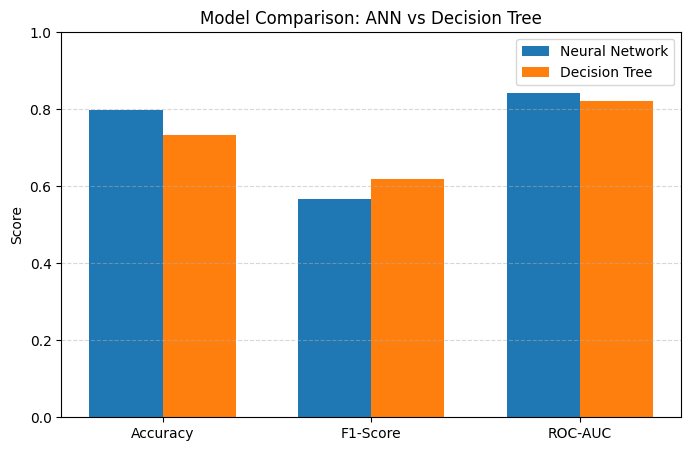

In [300]:
# Metrics to compare
metrics = ['Accuracy', 'F1-Score', 'ROC-AUC']

# ANN metric values
ann_values = [
    metrics_nn['Accuracy'],
    metrics_nn['F1-Score'],
    metrics_nn['ROC-AUC']
]

# Decision Tree metric values
dt_values = [
    metrics_dt['Accuracy'],
    metrics_dt['F1-Score'],
    metrics_dt['ROC-AUC']
]

# Bar positions
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))

# Create bars
plt.bar(x - width/2, ann_values, width, label='Neural Network')
plt.bar(x + width/2, dt_values, width, label='Decision Tree')

# Labels & formatting
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Model Comparison: ANN vs Decision Tree')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
